In [1]:
# pip install faiss-gpu-cu12

In [2]:
# pip install langchain-text-splitters

In [3]:
# pip install langchain-huggingface sentence-transformers

In [4]:
# pip install langchain-community

In [5]:
# pip install pypdf

In [6]:
# pip install jq

In [7]:
import os
import json
import pandas as pd

In [8]:
from typing import List, Optional, Dict

import faiss
import numpy as np
from tqdm import tqdm
from langchain_community.document_loaders import (
    PyPDFLoader,
    TextLoader,
    JSONLoader
)
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

import torch
from torch import Tensor
import torch.nn.functional as F

/home/russele7/practicum/dle/practicum_dle_sprint_7/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from matplotlib import pyplot as plt

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# main_path = '/content/drive/MyDrive/PRACTICUM_DLE/sprint_7/'
main_path = ''

# 1 EDA

In [12]:
data_path = main_path + 'nlp_s3_project/'
data_json_path = data_path + 'arxiv-metadata-s.json'
data_sample_path = data_path + 'sample_data.json'
data_csv_path = data_path + 'test_sample.csv'

In [13]:
# with open(data_path + 'sample_data.json', 'w') as file:
#   json.dump(train_data[:1000], file)

## 1.1 Train data

In [14]:
with open(data_json_path, 'r') as file:
  train_data = json.load(file)

In [15]:
with open(data_sample_path, 'r') as file:
  sample_data = json.load(file)

In [16]:
len(sample_data)

1000

In [17]:
df_test = pd.read_csv(data_csv_path)

In [18]:
df_train = pd.DataFrame(train_data[:1000])

In [19]:
df_train.head(3)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0038,Maxim A. Yurkin,"Maxim A. Yurkin, Alfons G. Hoekstra",The discrete dipole approximation: an overview...,"36 pages, 1 figure; added several corrections ...","J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 ...",10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.20...,None,physics.optics physics.comp-ph,http://creativecommons.org/licenses/by-nc-nd/4.0/,We present a review of the discrete dipole a...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2022-03-30,"[[Yurkin, Maxim A., ], [Hoekstra, Alfons G., ]]"
1,0704.0057,Philipp Werner,Philipp Werner and Andrew J. Millis,High-spin to low-spin and orbital polarization...,Published version,"Phys. Rev. Lett. 99, 126405 (2007)",10.1103/PhysRevLett.99.126405,None,cond-mat.str-el,None,We study the interplay of crystal field spli...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-11-13,"[[Werner, Philipp, ], [Millis, Andrew J., ]]"
2,0704.0060,Carlos Bertulani,"C.A. Bertulani, G. Cardella, M. De Napoli, G. ...",Coulomb excitation of unstable nuclei at inter...,"12 pages, 2 figures, accepted for publication ...","Phys.Lett.B650:233-238,2007",10.1016/j.physletb.2007.05.029,None,nucl-th,None,We investigate the Coulomb excitation of low...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-11-26,"[[Bertulani, C. A., ], [Cardella, G., ], [De N..."


## title

<Axes: >

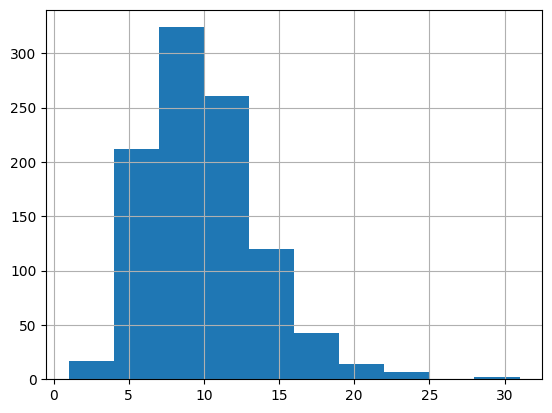

In [20]:
df_train['title'].apply(lambda x: len(x.split())).hist()

<Axes: >

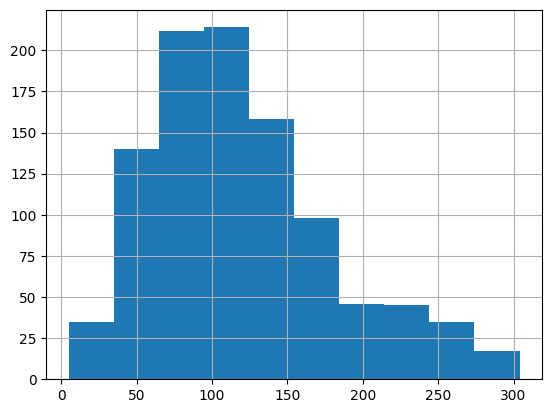

In [21]:
df_train['abstract'].apply(lambda x: len(x.split())).hist()

## submitter

In [22]:
df_train['submitter'].value_counts()

submitter
Damien Chablat               5
Gerhard Hensler              3
Francoise Heres-Renzetti     3
Yusuke Sasano                2
Rodrigo Ferreira Sobreiro    2
                            ..
Flavio Garcia                1
Lam Hui                      1
Benjamin Collins             1
Piotr Szymczak               1
Anton Andreev                1
Name: count, Length: 970, dtype: int64

## tags

In [23]:
categories_dict = {}
for cats in df_train['categories']:
  for cat in cats.split():
    if cat in categories_dict:
      categories_dict[cat] += 1
    else:
      categories_dict[cat] = 1

In [24]:
df_cats = pd.DataFrame([[k, v] for k, v in categories_dict.items()], columns=['category', 'count']).sort_values('count', ascending=False).reset_index(drop=True)
df_cats

,category,count
0,astro-ph,211
1,hep-ph,100
2,hep-th,100
3,gr-qc,70
4,cond-mat.mtrl-sci,55
...,...,...
107,q-fin.PM,1
108,physics.ed-ph,1
109,cs.AI,1
110,cs.CV,1


In [25]:
df_train['categories'].apply(lambda x: len(x.split())).value_counts().reset_index()

,categories,count
0,1,645
1,2,246
2,3,74
3,4,26
4,5,5
5,6,3
6,7,1


## update_date

<Axes: >

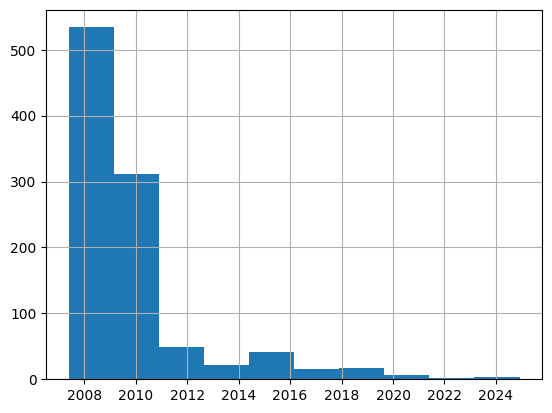

In [26]:
pd.to_datetime(df_train['update_date']).hist()

## versions

In [27]:
df_train['versions'].apply(lambda x: len(x)).value_counts()

versions
1     622
2     266
3      83
4      21
5       5
6       2
10      1
Name: count, dtype: int64

## authors_parsed

In [28]:
df_train.head(2)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0038,Maxim A. Yurkin,"Maxim A. Yurkin, Alfons G. Hoekstra",The discrete dipole approximation: an overview...,"36 pages, 1 figure; added several corrections ...","J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 ...",10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.20...,None,physics.optics physics.comp-ph,http://creativecommons.org/licenses/by-nc-nd/4.0/,We present a review of the discrete dipole a...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2022-03-30,"[[Yurkin, Maxim A., ], [Hoekstra, Alfons G., ]]"
1,0704.0057,Philipp Werner,Philipp Werner and Andrew J. Millis,High-spin to low-spin and orbital polarization...,Published version,"Phys. Rev. Lett. 99, 126405 (2007)",10.1103/PhysRevLett.99.126405,None,cond-mat.str-el,None,We study the interplay of crystal field spli...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-11-13,"[[Werner, Philipp, ], [Millis, Andrew J., ]]"


In [29]:
df_train['authors_parsed'].apply(lambda x: len(x)).value_counts().reset_index()

,authors_parsed,count
0,2,268
1,1,260
2,3,195
3,4,121
4,5,56
5,6,36
6,7,24
7,9,10
8,8,9
9,10,5


## 1.2 Test data

In [30]:
df_test.head()

,id,abstract,query
0,2412.16732,A new platinate was recently discovered when...,What unique composition and decomposition beha...
1,nucl-th/9602019,The production cross sections of various fra...,How does the inclusion of statistical decay af...
2,2501.05500,This survey provides a comprehensive examina...,What are the core components of modern zero-kn...
3,2506.20892,A critical challenge for operating fusion burn...,How does impurity seeding affect the timing an...
4,2208.02031,"In this work, we present the first corpus fo...",What is the primary challenge of the newly dev...


In [31]:
df_test.loc[0, 'query']

'What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24 exhibit under thermal conditions?'

In [32]:
df_test.loc[0, 'abstract']

"  A new platinate was recently discovered when Nd2O3 was explored as a platinum\ncapture material in the Ostwald process, formed by a direct reaction between\nPtO2(g) and Nd2O3. The crystal structure of this new platinate and its\ncomposition, Nd10.67Pt4O24 , are here reported for the first time. The compound\nis synthesized either by a direct reaction using PtO2(g) or by the citric acid\nchemical route. Based on 3-dimensional electron diffraction data and Rietveld\nrefinement of high-resolution synchrotron and neutron powder diffraction data,\nwe accurately describe its crystal structure in space group I41/a. The compound\nis structurally related to the Ln11-xSrxIr4O24 (Ln = La, Pr, Nd, Sm) phases\nwith a double-perovskite (A2BB'O6) like crystal structure and A-site\ncation-deficiency. Owing to the fixed oxidation state of Pt(IV), two of the\nfour Nd-sites are partly occupied to provide charge neutrality, with the Nd4\nsite taking a split position. On heating, Nd10.67Pt4O24 decompose

<Axes: >

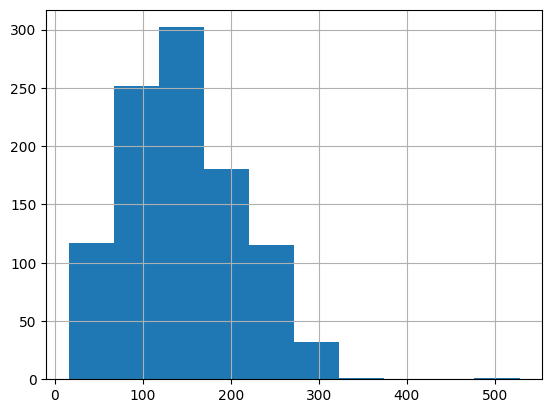

In [33]:
df_test['abstract'].apply(lambda x: len(x.split())).hist()

<Axes: >

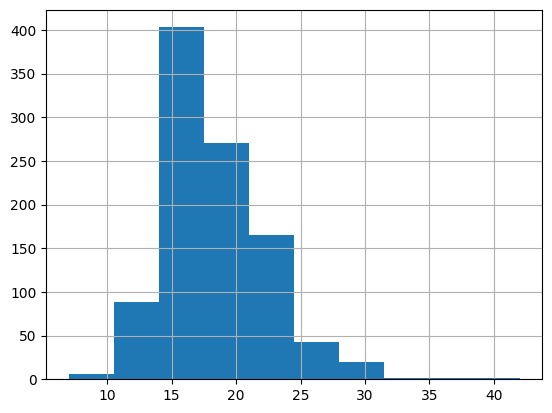

In [34]:
df_test['query'].apply(lambda x: len(x.split())).hist()

# Выводы по EDA

1. как вы будете решать задачу;
- Сделаем RAG+LLM
2. какие подходы к поиску примените и почему;
- Графовая БД index какой-то
3. какие модели выберете и от каких ограничений будете отталкиваться;
- Как в примерах
4. из чего будет состоять ваша система.
- Загрузчик данных
- Ембеддер данных
- БДшка векторная и индекс
- функция поиска релевантных данных к запросу
- функция ранжирования релеввантных
- Формирование комби запроса с учетом релевантных
- Инференс с ЛЛМ
- расчет метрики

# 2 Этап 2. Реализация retrieval-системы

In [35]:
train_data[0]

{'id': '0704.0038',
 'submitter': 'Maxim A. Yurkin',
 'authors': 'Maxim A. Yurkin, Alfons G. Hoekstra',
 'title': 'The discrete dipole approximation: an overview and recent developments',
 'comments': '36 pages, 1 figure; added several corrections according to the\n  published erratum except for Eq.(5) (it was correct in the original paper)',
 'journal-ref': 'J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 (2007); Erratum:\n  J.Quant.Spectrosc.Radiat.Transf. 171, 82-83 (2016)',
 'doi': '10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.2015.11.025',
 'report-no': None,
 'categories': 'physics.optics physics.comp-ph',
 'license': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
 'abstract': '  We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped particles. We\nput the method in historical context and discuss recent developments, taking\nthe viewpoint of a general framework based on the integral equation

In [36]:
# from langchain_core.documents import Document
# def load_from_list_of_dicts(data: list[dict]) -> list[Document]:
#     """
#     Converts a list of dictionaries into a list of LangChain Document objects.

#     Each dictionary is expected to have 'page_content' and optional 'metadata' keys.
#     """
#     documents = []
#     for item in data:
#         page_content = item.get('title') + '\n' + item.get('abstract')
#         metadata = {'source': item.get('categories')}
#         # Create a Document object
#         doc = Document(page_content=page_content, metadata=metadata)
#         documents.append(doc)
#     return documents

In [37]:
def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["categories"] = record["categories"]
    metadata["id"] = record["id"]
    return metadata

In [ ]:
class RAG:

    def __init__(
        self,
        embedder_name: str = "intfloat/e5-base-v2",
        reranker_name: str = "cross-encoder/ms-marco-MiniLM-L-12-v2",
        chunk_size: int = 500,
        chunk_overlap: int = 125,
        device: Optional[str] = None,
    ):
        self.device = device or ("cuda"
                                 if torch.cuda.is_available() else "cpu")
        self.emb_tokenizer = AutoTokenizer.from_pretrained(embedder_name)
        self.embedder = AutoModel.from_pretrained(embedder_name).to(
            self.device)
        self.embedder.eval()

        self.rr_tokenizer = AutoTokenizer.from_pretrained(
            reranker_name,
            padding_side='left')
        self.reranker = AutoModelForCausalLM.from_pretrained(
            reranker_name).to(self.device)
        self.reranker.eval()

        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
        )
        self.index = None
        self.doc_store = []

        self.max_length = 8192
        self.token_false_id = self.rr_tokenizer.convert_tokens_to_ids("no")
        self.token_true_id = self.rr_tokenizer.convert_tokens_to_ids("yes")
        prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".<|im_end|>\n<|im_start|>user\n"
        suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
        self.prefix_tokens = self.rr_tokenizer.encode(prefix,
                                                      add_special_tokens=False)
        self.suffix_tokens = self.rr_tokenizer.encode(suffix,
                                                      add_special_tokens=False)

    def _generate_embeddings(self, texts: List[str]) -> np.ndarray:
        inputs = self.emb_tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=self.max_length,
        ).to(self.device)

        with torch.no_grad():
            outputs = self.embedder(**inputs)

        inputs.to("cpu")
        embeddings = self.last_token_pool(outputs.last_hidden_state,
                                          inputs.attention_mask).cpu()
        return F.normalize(embeddings, p=2, dim=1).numpy()

    @staticmethod
    def last_token_pool(last_hidden_states: Tensor,
                        attention_mask: Tensor) -> Tensor:
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[
                torch.arange(batch_size, device=last_hidden_states.device),
                sequence_lengths]

    # Define the metadata extraction function.


    def load_and_process_file(self, file_path: str) -> List[Document]:
        """Загрузка и экстракция данных из файлов"""
        ext = os.path.splitext(file_path)[1]
        if ext == ".json":
            loader = JSONLoader(
              file_path=file_path,
              jq_schema='.[]',
              content_key="abstract",
              text_content=True,
              # is_content_key_jq_parsable=True,
              metadata_func=metadata_func
            )
        else:
            raise ValueError(f"Unsupported file type: {ext}")

        docs = loader.load()

        return self.text_splitter.split_documents(docs)


    def build_index(self, file_paths: List[str], batch_size: int = 4) -> None:
        """Строим индекс FAISS"""
        all_docs = []
        for path in file_paths:
            all_docs.extend(self.load_and_process_file(path))
        self.doc_store = all_docs

        # Вычислим numpy-эмбеддинги по батчам
        embeddings = []
        for i in tqdm(range(0, len(all_docs), batch_size)):
            batch = [doc.page_content for doc in all_docs[i:i + batch_size]]
            embeddings.append(self._generate_embeddings(batch))

        embeddings = np.concatenate(embeddings)

        # Инициализируем индекс
        self.index = faiss.IndexFlatL2(embeddings.shape[1])
        self.index.add(embeddings)

    @staticmethod
    def get_detailed_instruct(task_description: str, query: str):
        return f'Instruct: {task_description}\nQuery:{query}'

    @staticmethod
    def format_reranker_instruction(query, doc, instruction=None):
        if instruction is None:
            instruction = 'Given a web search query, retrieve relevant passages that answer the query'
        output = "<Instruct>: {instruction}\n<Query>: {query}\n<Document>: {doc}".format(
            instruction=instruction, query=query, doc=doc)
        return output

    def process_inputs(self, pairs):
        """Обработка данных для реранкера"""
        inputs = self.rr_tokenizer(pairs,
                                   padding=False,
                                   truncation='longest_first',
                                   return_attention_mask=False,
                                   max_length=self.max_length -
                                   len(self.prefix_tokens) -
                                   len(self.suffix_tokens))
        for i, ele in enumerate(inputs['input_ids']):
            inputs['input_ids'][
                i] = self.prefix_tokens + ele + self.suffix_tokens
        inputs = self.rr_tokenizer.pad(inputs,
                                       padding=True,
                                       return_tensors="pt",
                                       max_length=self.max_length)

        # переносим тензоры на девайс ранжирующей модели
        for key in inputs:
            inputs[key] = inputs[key].to(self.device)
        return inputs

    def search(self,
               query: str,
               k: int = 5,
               task: str = None):
        if self.index is None:
            raise ValueError("Index not initialized")

        if task is None:
            task = 'Given a web search query, retrieve relevant passages that answer the query'

        query_embedding = self._generate_embeddings([query])
        distances, indices = self.index.search(query_embedding, k)
        return distances, indices

    @torch.no_grad()
    def compute_logits(self, inputs):
        batch_scores = self.reranker(**inputs).logits[:, -1, :]
        true_vector = batch_scores[:, self.token_true_id]
        false_vector = batch_scores[:, self.token_false_id]
        batch_scores = torch.stack([false_vector, true_vector], dim=1)
        batch_scores = torch.nn.functional.log_softmax(batch_scores, dim=1)
        scores = batch_scores[:, 1].exp().tolist()
        return scores

    def rerank(self, query: str, documents: List[str], batch_size=1):
        pairs = []
        for d in documents:
            pairs.append(self.format_reranker_instruction(query, d))

        scores = []
        for i in range(0, len(pairs), batch_size):

            inputs = self.process_inputs(pairs[i:i + batch_size])
            sc = self.compute_logits(inputs)
            scores.extend(sc)
        return scores

In [39]:
# # освободим место на GPU
# torch.cuda.empty_cache()
# rag.embedder.to("cpu")
# rag.reranker.to("cpu")

In [40]:
rag = RAG(device="cuda")

{"timestamp":"2026-02-05T20:43:17.629063Z","level":"WARN","fields":{"message":"Reqwest(reqwest::Error { kind: Request, source: hyper_util::client::legacy::Error(Connect, Custom { kind: Other, error: Custom { kind: InvalidData, error: InvalidCertificate(NotValidForNameContext { expected: DnsName(\"cas-server.xethub.hf.co\"), presented: [\"DnsName(\\\"satservicos.dev.br\\\")\", \"DnsName(\\\"*.satservicos.dev.br\\\")\"] }) } }) }). Retrying..."},"filename":"/home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs","line_number":242}
{"timestamp":"2026-02-05T20:43:17.629172Z","level":"WARN","fields":{"message":"Retry attempt #0. Sleeping 1.920248476s before the next attempt"},"filename":"/root/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/reqwest-retry-0.7.0/src/middleware.rs","line_number":171}
{"timestamp":"2026-02-05T20:43:21.687661Z","level":"WARN","fields":{"message":"Reqwest(reqwest::Error { kind: Request, source: hyper_util::client::legacy::Error(Connect, Custom { k

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of BertLMHeadModel were not initialized from the model checkpoint at cross-encoder/ms-marco-MiniLM-L-12-v2 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
rag.build_index([data_sample_path], batch_size=4)

100%|██████████| 570/570 [00:16<00:00, 35.40it/s]


In [43]:
rag.doc_store[-1]

Document(metadata={'source': '/home/russele7/practicum/dle/practicum_dle_sprint_7/nlp_s3_project/sample_data.json', 'seq_num': 1000, 'categories': 'hep-ex hep-ph', 'id': '0710.2378'}, page_content='These proceedings describe Sleuth, a quasi-model-independent search strategy\ntargeting new electroweak scale physics, and its application to 927 pb^-1 of\nCDF II data. Exclusive final states are analyzed for an excess of data beyond\nthe Standard Model prediction at large summed scalar transverse momentum. This\nanalysis of high-pT data represents one of the most encompassing searches so\nfar conducted for new physics at the energy frontier.')

In [44]:
q = df_test.loc[0, 'query']
id_true = df_test.loc[0, 'id']
q, id_true

('What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24 exhibit under thermal conditions?',
 '2412.16732')

In [45]:
_, I = rag.search(q, k=100)

In [46]:
candidates = [rag.doc_store[i].page_content for i in I[0]]

In [47]:
k = 5

In [48]:
candidates[0]

'in thermal equilibrium. Such an asymptotic behavior is due to the NLO\ndissociation cross section converging to a nonvanishing value in the high\nenergy limit.'

In [49]:
scores = rag.rerank(q, candidates)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/russele7/practicum/dle/practicum_dle_sprint_7/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2714: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


RuntimeError: The size of tensor a (169) must match the size of tensor b (92) at non-singleton dimension 1

In [ ]:
scores = rag.rerank(q, candidates)
array = np.array(scores)
indices = np.argsort(array)[::-1][:k]

In [ ]:
mrr5_list = []
for index, row in tqdm(df_test.iterrows()):
  # print(index, row['id'])
  q = row['query']
  id_true = row['id']
  _, I = rag.search(q, k=5)
  relevant_flags = [rag.doc_store[i].metadata['id'] == id_true for i in I[0]]
  relev_index = find_index_next(relevant_flags, True, np.inf)
  mrr5_list.append(1 / relev_index)

In [ ]:
MRR5 = sum(mrr5_list) / len(mrr5_list)
MRR5

In [ ]:
1 / np.inf

In [ ]:
I

In [ ]:
relevant_flags = [rag.doc_store[i].metadata['id'] == id_true for i in I[0]]
relevant_flags

In [ ]:
relevant_flags = [True, False, False, True, False]

In [ ]:
def find_index_next(my_list, target_value, not_found_value):
    return next((i + 1 for i, x in enumerate(my_list) if x == target_value), not_found_value)

In [ ]:
find_index_next(relevant_flags, True, 5)

In [ ]:
find_index_or_none_next(relevant_flags, True)

In [ ]:
relevant_flags.index(1)

In [ ]:
mrr@5 =

In [ ]:
next((item for item in relevant_flags if item), False)

In [ ]:
[rag.doc_store[i].metadata['id'] for i in I[0]]

In [ ]:
candidates = [rag.doc_store[i].page_content for i in I[0]]

In [ ]:
rag.doc_store[23].metadata['id']